# 題目
- 科系、職務與待遇：大數據時代下的社會學與勞動市場

- 挑戰：分析技術沒有跟上
- 機會：溝通能力
> 我會直接展示很多用 python 處理資料的邏輯，你們也可以想看看怎麼用SPSS實現，有沒有辦法做到&哪個快

探討學用之間的落差對於系所與學生來說都是相當重要的分析議題，系所可以藉此確認教學目標是否與勞動市場接軌，而對於學生來說則可以提早思考自己的職涯規劃。在這次的工作坊中我將帶著大家透過 Python 開發人力銀行的網路爬蟲程式，藉此截取人力銀行網站上 20 萬筆的職缺資料。並藉由這些職缺中的科系、職務、要求技能、待遇...等等資訊進行分析，檢視勞動市場是如何看待不同科系的學生與勞動狀況。最後我將根據分析的結果給予相關建議，並說明在大數據時代下的社會學系有哪些機會與挑戰。

# 載入套件
- miniconda 下載

In [1]:
import pandas as pd
import numpy as np
import os
import re
import requests
import prince
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 載入資料

- specialty:擅長工具
- skill:工作技能

## 讀取資料

In [2]:
path = '../../DataScience/WebCrawler/HumanResource_104/data/JobDetail.pkl'
df = pd.read_pickle(path)
print(df.shape)
df.head(3)

(200729, 34)


,jobName,appearDate,custName,hrName,email,phone,acceptRole,workExp,edu,major,...,workType,addressRegion,addressDetail,manageResp,businessTrip,workPeriod,vacationPolicy,startWorkingDay,hireType,industry
0,作業員,2020/09/15,總信食品有限公司,胡慧敏小姐,,,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,高中、專科、大學,[],...,[],台中市南屯區,工業區二十二路17號,不需負擔管理責任,無需出差外派,日班/晚班，需輪班,週休二日,不限,0,食品什貨批發業
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),2020/09/15,國泰醫療財團法人國泰綜合醫院,李宿華小姐,sue@cgh.org.tw,,"[{'code': 1, 'description': '上班族'}, {'code': 6...",不拘,專科、大學,[護理助產相關],...,[],新北市汐止區,建成路59巷2號,不需負擔管理責任,無需出差外派,日班/晚班，需輪班,依公司規定,不限,0,醫院
2,印刷見習技師,2020/09/18,康揚特殊美術印刷股份有限公司,邱先生,ford521213@yahoo.com.tw,,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,高中、專科、大學,[],...,[],台北市南港區,南港路三段50巷9號5樓,不需負擔管理責任,無需出差外派,日班/晚班，08:00~17:30，需輪班,週休二日,一週內,0,印刷業


In [3]:
# df.head(1000).to_excel('../../DataScience/WebCrawler/HumanResource_104/data/JobDetail.xlsx',index=False)

## 保留需要的欄位
- jobName 職缺名稱
- custName 公司名稱
- workExp 工作經歷
- edu 教育程度
- major 科系
- specialty 擅長工具
- skill 工作技能
- jobDetail 工作內容
- jobCategory 職務類別
- salary 待遇
- salaryMin 最低待遇
- salaryMax 最高待遇
- salaryType 待遇類型
- addressRegion 縣市區域
- addressDetail 地址
- industry 產業

In [4]:
df = df.loc[:,['jobName','custName','workExp','edu','major', 'specialty','skill','jobDetail', 'jobCategory',
              'salary','salaryMin','salaryMax','salaryType','addressRegion','addressDetail','industry']]
df.head(3)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,[護理助產相關],[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,[],[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業


# 高薪的工作在哪裡？
> 練習根據不同的薪資型態統一整理成年薪

In [5]:
df['salary']

0         月薪28,000~30,000元
1         月薪41,000~43,000元
2         月薪26,000~36,000元
3         月薪23,800~40,000元
4                     待遇面議
                ...       
200724                待遇面議
200725    月薪27,000~80,000元
200726                待遇面議
200727    月薪35,000~50,000元
200728    月薪28,000~40,000元
Name: salary, Length: 200729, dtype: object

## 薪資有哪些類型?
- salaryType
 - 10: 面議
 - 20: 論件計酬
 - 30: 時薪
 - 40: 日薪
 - 50: 月薪
 - 60: 年薪

In [6]:
df.groupby('salaryType').head(1).sort_values('salaryType')

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,[],"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業
22,TOP1000大培訓專案行銷經理(承攬約),中國人壽保險(股)公司_至慶通訊處 (核可文號:中壽高屏業支網第20033101號),不拘,高中以上,[],[],[],歡歡迎主動積極、願意學習，想要開創屬於自己事業的菁英夥伴加入我們的行列。 \r\n ...,"[{'code': '2005003001', 'description': '國內業務主管...","論件計酬1~99,999元",1,99999,20,高雄市鼓山區,明誠四路156號7樓,人身保險業
382,才藝老師 (英文教學),芝麻街美語學校_新北市私立南蒂亞幼兒園,1年以上,專科以上,[],[],[],"1.可用英文上課,營造美語教學環境\r\n2.專長為舞蹈、圍棋、積木、珠心算、美術、電子琴（...","[{'code': '2016002016', 'description': '其他才藝類老...",時薪400~600元,400,600,30,新北市林口區,麗園路94號,學前教育事業
112,廚房助手,愛欣食品有限公司,不拘,高中以下、高中、專科、大學,[],[],[],煮飯.煮湯.油鍋幫忙\n學校送餐.有廚房經驗.\n要能搬重物.會開貨車\n有中餐丙級證照者....,"[{'code': '2006001002', 'description': '中餐廚師'}...","日薪1,500元",1500,1500,40,新北市淡水區,八勢一街1號,其他食品製造業
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業
310,營造工程師(無經驗可培訓),建銘營造股份有限公司,不拘,大學、碩士,"[建築相關, 土木工程相關]",[],[],1.指揮並監督工人，以控制工程的施工進度與施工品質。\r\n2.材料進料時驗收\r\n3.編...,"[{'code': '2012002002', 'description': '工地監工／主...","年薪504,000~570,000元",504000,570000,60,新竹市,東區新竹科學園區,建築工程業


## 薪資統一成月薪
- 新鮮人沒有籌碼，通常都是拿最低薪資qq
- 面議(10): 直接是 4萬以上
- 年薪(60): 最低薪資除14計算來計算出月薪
- 月薪(50): 維持原月薪
- 日薪(40): 最低薪資*20個工作天
- 時薪(30): 最低薪資\*20個工作天\*8的工時
- 論件計酬(20): 當成0丟掉~

In [7]:
# 轉換成月薪
df['nsalaryMin'] = np.select(condlist = [df['salaryType'] == 10, # 面議, 
                                         df['salaryType'] == 60, # 年薪
                                         df['salaryType'] == 50, # 月薪
                                         df['salaryType'] == 40, # 日薪
                                         df['salaryType'] == 30], # 時薪
                             choicelist = [40000,
                                           df['salaryMin']/14,
                                           df['salaryMin'],
                                           df['salaryMin']*20,                                           
                                           df['salaryMin']*20*8])
df.groupby('salaryType').head(1).sort_values('salaryType')

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,[],"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
22,TOP1000大培訓專案行銷經理(承攬約),中國人壽保險(股)公司_至慶通訊處 (核可文號:中壽高屏業支網第20033101號),不拘,高中以上,[],[],[],歡歡迎主動積極、願意學習，想要開創屬於自己事業的菁英夥伴加入我們的行列。 \r\n ...,"[{'code': '2005003001', 'description': '國內業務主管...","論件計酬1~99,999元",1,99999,20,高雄市鼓山區,明誠四路156號7樓,人身保險業,0.0
382,才藝老師 (英文教學),芝麻街美語學校_新北市私立南蒂亞幼兒園,1年以上,專科以上,[],[],[],"1.可用英文上課,營造美語教學環境\r\n2.專長為舞蹈、圍棋、積木、珠心算、美術、電子琴（...","[{'code': '2016002016', 'description': '其他才藝類老...",時薪400~600元,400,600,30,新北市林口區,麗園路94號,學前教育事業,64000.0
112,廚房助手,愛欣食品有限公司,不拘,高中以下、高中、專科、大學,[],[],[],煮飯.煮湯.油鍋幫忙\n學校送餐.有廚房經驗.\n要能搬重物.會開貨車\n有中餐丙級證照者....,"[{'code': '2006001002', 'description': '中餐廚師'}...","日薪1,500元",1500,1500,40,新北市淡水區,八勢一街1號,其他食品製造業,30000.0
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
310,營造工程師(無經驗可培訓),建銘營造股份有限公司,不拘,大學、碩士,"[建築相關, 土木工程相關]",[],[],1.指揮並監督工人，以控制工程的施工進度與施工品質。\r\n2.材料進料時驗收\r\n3.編...,"[{'code': '2012002002', 'description': '工地監工／主...","年薪504,000~570,000元",504000,570000,60,新竹市,東區新竹科學園區,建築工程業,36000.0


In [8]:
df.sort_values('nsalaryMin', ascending=False).head(10)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
198309,TZ頂埔捷運站✤高薪4.5萬【固定班_週領6千】免費供餐✤免經驗➜轉職/待業都OK,艾肯國際開發有限公司,不拘,不拘,[],[],[],▃▃▃ 加Line好友詢問、預約面試 ▃▃▃\n★【週週領薪】➜芸小姐☎：097283788...,"[{'code': '2010001002', 'description': '作業員／包裝...","時薪40,000~52,000元",40000,52000,30,新北市土城區,✤【土城 中山路】➜頂埔捷運站走路10分鐘】✤,人力仲介代徵,6400000.0
150403,淡水機動保全員,泰翔保全股份有限公司,不拘,不拘,[],[],[],1.巡邏建築物與周遭環境，留意可疑線索，確保門窗安全。\r\n2.回應警報器並且調查引起警鈴...,"[{'code': '2017002001', 'description': '保全人員／警...","時薪34,000元",34000,34000,30,新北市淡水區,,保全樓管相關業,5440000.0
165595,數理輔導老師,台中市私立林子文理短期補習班,不拘,大學、碩士,[],[],[],協助輔導課業,"[{'code': '2016002011', 'description': '語文補習班老...","時薪30,000~45,000元",30000,45000,30,台中市西區,英才路455號,補習班,4800000.0
110402,管家,岳生生技股份有限公司,2年以上,高中以上,[],[],[],1.協助家務處理.\r\n2.外出接送或定點接送\r\n\r\n,"[{'code': '2018002013', 'description': '家事服務人員'}]","時薪30,000~35,000元",30000,35000,30,桃園市楊梅區,獅四路1號,其他食品製造業,4800000.0
111141,美容師 (漢神巨蛋),曼蒂造型設計,不拘,不拘,[],[],[],1.願接受本公司教育培訓。(研修期間薪資23800)\n2.有志學習專業一技之長者佳，對美容...,"[{'code': '2006003001', 'description': '美容工作者'...","時薪30,000~60,000元",30000,60000,30,高雄市左營區,博愛二路777號5樓,美髮業,4800000.0
62933,模組廠-模組設備常日班工程師(屏東廠),元晶太陽能科技股份有限公司,3年以上,專科、大學,"[工程學科類, 機械工程相關, 電機電子工程相關]",[],[],1.生產設備日常保養與故障排除\r\n2.機台破片率改善\r\n3.生產設備零、組件維修\r...,"[{'code': '2009002007', 'description': '半導體設備工...","時薪30,000~60,000元",30000,60000,30,屏東縣屏東市,大溪路335-12號,光電產業,4800000.0
2203,嬰幼兒托育人員/護理人員(可兼任),臺北市私立快樂托嬰中心,不拘,高中、專科、大學,"[學前教育相關, 兒童保育相關, 護理助產相關]",[],[],1. 0-3歲 嬰幼兒的安全與生活照顧\r\n2. 嬰幼兒教保活動帶領\r\n3. 親職溝通...,"[{'code': '2016002020', 'description': '教保員'},...","時薪29,000~39,000元",29000,39000,30,台北市內湖區,民權東路六段282號2樓,學前教育事業,4640000.0
44223,早班門市,大吉利生活百貨館_宏昇商行,不拘,不拘,[],[],[],1.負責介紹及銷售門市商品。\r\n2.提供顧客之接待與需求服務（如：電話諮詢、調貨、修改、...,"[{'code': '2005002004', 'description': '門市／店員／...","時薪28,000~35,000元",28000,35000,30,台北市中山區,錦州街386號1樓,百貨相關業,4480000.0
177086,清潔員晚班 (台北市大安區、信義區),一訂股份有限公司,不拘,不拘,[],[],[],1.工作內容：夜店/酒吧/餐酒，主要維護現場及廁所清潔，工作內容很簡單\n2.上班時間：排班...,"[{'code': '2018002012', 'description': '清潔工／資源...","時薪27,000~35,000元",27000,35000,30,台北市信義區,或大安區,家事服務業,4320000.0
97489,(社區教育)社區烘培坊-烘焙助手,甘樂文創志業股份有限公司,2年以上,大學、碩士,[],[],[],工作內容\r\n烘培人員工作內容\r\n1.烘培麵包及點心研發與製作\r\n2.店鋪服務、管...,"[{'code': '2006001005', 'description': '麵包師'},...","時薪26,400元",26400,26400,30,新北市三峽區,,廣告行銷公關業,4224000.0


> 結論: 乖乖找正常的工作比較合適~

# 哪些工作會想要找社會學系的學生?
- 因為是科系是複選題，所以需要處理一下資料!

## 展開科系

In [9]:
df_exp_by_major = df.explode('major')
df_exp_by_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,NaN,[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業,26000.0
3,證券營業員(南科分公司),國票綜合證券股份有限公司,不拘,專科以上,NaN,[],[],1.對證券現貨、期貨及新金融商品投資具興趣。 \r\n2.自認可吃苦耐勞、勇於負責者。 \r...,"[{'code': '2003002005', 'description': '金融營業員'...","月薪23,800~40,000元",23800,40000,50,台南市新市區,',證券及期貨業,23800.0
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,NaN,"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,學前教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,綜合教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,專業科目教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200727,Java程式開發工程師,藍科數位科技股份有限公司,1年以上,專科以上,NaN,"[{'code': '12001003025', 'description': 'Java'}]","[{'code': '11009002008', 'description': '軟體工程系...",Java Web應用程式維護、開發\r\n1. 具備 Java 基礎知識即可，我們很願意帶你...,"[{'code': '2007001004', 'description': '軟體設計工程...","月薪35,000~50,000元",35000,50000,50,台北市內湖區,行愛路151號2樓之2,電腦軟體服務業,35000.0


## 篩選社會學的職缺

In [10]:
soc_jobs = df_exp_by_major.loc[df_exp_by_major['major']=='社會學相關',:].copy()
soc_jobs.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0


## 斷詞

In [11]:
# 串接職缺名稱與工作描述
soc_jobs['jobDetail2'] = soc_jobs['jobName'] + soc_jobs['jobDetail']
soc_jobs.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,jobDetail2
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0,社工員(收出養服務中心)1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2...


In [12]:
import jieba

In [13]:
jieba.lcut('我的外送什麼時候才要來?')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TL_Yu\AppData\Local\Temp\jieba.cache
Loading model cost 1.423 seconds.
Prefix dict has been built successfully.


['我', '的', '外', '送', '什麼', '時候', '才', '要來', '?']

In [14]:
jieba.add_word('外送')

In [15]:
jieba.lcut('我的外送什麼時候才要來?')

['我', '的', '外送', '什麼', '時候', '才', '要來', '?']

> 斷詞會需要依分析的場域來花一些時間建立專屬辭典

In [16]:
re.sub('[^\u4e00-\u9fa5]','',string='我的外送什麼時候才要來?')

'我的外送什麼時候才要來'

In [17]:
def sent2words(sent):
    sent = re.sub('[^\u4e00-\u9fa5]', '', sent) # 只保黎文本中的中文
    seg_list = jieba.lcut(sent) # 斷詞
    seg_list = [word for word in seg_list if len(word) >=2] # 保留大於兩個字的詞
    return seg_list

In [18]:
soc_jobs['jobDetail3'] = soc_jobs['jobDetail2'].apply(lambda x: sent2words(x))
soc_jobs

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,jobDetail2,jobDetail3
108,社工員(收出養服務中心),財團法人忠義社會福利事業基金會,不拘,大學以上,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2.團體工作：收出養服務相...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪31,000~36,000元",31000,36000,50,台北市文山區,,社會福利服務業,31000.0,社工員(收出養服務中心)1.個案工作：國內外收出養個案服務處遇、資源結合、宣導等。\r\n2...,"[社工, 員收, 出養, 服務中心, 個案, 工作, 國內外, 收出, 個案, 服務處, 資..."
345,教保老師(恆愛發展中心),財團法人第一社會福利基金會,不拘,高中、專科、大學,社會學相關,[],[],訓練心智障礙學員的生活技能及職業陶冶,"[{'code': '2016002006', 'description': '特殊教育教師...","月薪28,000~34,000元",28000,34000,50,台北市信義區,松隆路36號6樓,社會福利服務業,28000.0,教保老師(恆愛發展中心)訓練心智障礙學員的生活技能及職業陶冶,"[教保, 老師, 恆愛, 發展, 中心, 訓練, 心智, 障礙, 學員, 生活, 技能, 職..."
871,社工,財團法人桃園市私立觀音愛心家園,不拘,大學、碩士,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],從事個案管理、社資聯繫等。\r\n應徵者需具備社工相關科系畢業或修社工相關學分具有社工資格。,"[{'code': '2016002018', 'description': '社工人員'}...","月薪29,000~36,000元",29000,36000,50,桃園市觀音區,成功路一段250巷21號,社會福利服務業,29000.0,社工從事個案管理、社資聯繫等。\r\n應徵者需具備社工相關科系畢業或修社工相關學分具有社工資格。,"[社工, 從事, 個案, 管理社, 聯繫, 應徵者, 具備, 社工, 相關, 科系, 畢業,..."
1569,社工員,財團法人台灣基督教門諾會附設花蓮縣私立善牧中心,1年以上,大學,社會學相關,"[{'code': '12001008003', 'description': 'Excel...","[{'code': '11002002005', 'description': '專案規劃執...",1.方案執行與核銷。\r\n2.安置家園業務執行。\r\n3.行政業務。\r\n4.完成年度...,"[{'code': '2016002018', 'description': '社工人員'}]","月薪32,000~34,000元",32000,34000,50,花蓮縣花蓮市,中美路61號,社會福利服務業,32000.0,社工員1.方案執行與核銷。\r\n2.安置家園業務執行。\r\n3.行政業務。\r\n4.完...,"[社工, 方案, 執行, 核銷, 安置, 家園, 業務, 執行, 行政, 業務, 完成, 年..."
1818,志工管理專員(都監/信眾監院室),財團法人靈鷲山佛教基金會,1年以上,大學,社會學相關,"[{'code': '12001008003', 'description': 'Excel...",[],1.志工管理\r\n2.志工回山執勤服務協調\r\n3.志工組織,"[{'code': '2004001006', 'description': '活動企劃人員...","月薪28,000~37,000元",28000,37000,50,新北市永和區,保生路2號21樓(234),宗教組織,28000.0,志工管理專員(都監/信眾監院室)1.志工管理\r\n2.志工回山執勤服務協調\r\n3.志工組織,"[志工, 管理, 專員, 監信眾, 監院, 室志工, 管理, 志工, 回山, 執勤, 服務,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196856,居家服務督導員-雲林居家式長照機構,財團法人伊甸社會福利基金會,不拘,大學,社會學相關,[],[],1.居家服務個案訪視、派案。\n2.個案記錄撰寫與管理、相關系統資料鍵入與維護。\n3.居服...,"[{'code': '2015002012', 'description': '居家服務督導...","月薪32,000~36,000元",32000,36000,50,雲林縣北港鎮,新德路108號,社會福利服務業,32000.0,居家服務督導員-雲林居家式長照機構1.居家服務個案訪視、派案。\n2.個案記錄撰寫與管理、相...,"[居家, 服務, 督導員, 雲林, 居家, 機構, 居家, 服務, 個案, 訪視, 派案, ..."
197588,研究助理,高雄醫學大學_人力資源室,不拘,大學,社會學相關,[],[],1. 協助送審計畫 \n2. 研究收案（聯絡個案、問卷與認知功能評估、各單位聯繫） \n3....,"[{'code': '2016001013', 'description': '研究助理'}]","月薪32,450元",32450,32450,50,高雄市三民區,十全一路100號,大專校院教育事業,32450.0,研究助理1. 協助送審計畫 \n2. 研究收案（聯絡個案、問卷與認知功能評估、各單位聯繫） ...,"[研究, 助理, 協助, 審計, 研究, 收案, 聯絡, 個案, 問卷, 認知, 功能, 評..."
198539,代操作人員【駐廠代表】,英屬開曼群島商納諾股份有限公司台灣分公司,2年以上,高中,社會學相關,[],[],"1.監控廠內電儀設備運作,觀察機械的運作情形，偵測設備不足處或機械故障處，必要時須進行調整。...","[{'code': '2010001002', 'description': '作業員／包裝...","月薪30,000~40,000元",30000,40000,50,高雄市前鎮區,高雄市前鎮區南7路1號,其他相關製造業,30000.0,"代操作人員【駐廠代表】1.監控廠內電儀設備運作,觀察機械的運作情形，偵測設備不足處或機械故障...","[操作, 人員, 駐廠, 代表, 監控, 廠內, 電儀, 設備, 運作, 觀察, 機械, 運..."
199117,勝利加油站就業服務員,財團法人台北市勝利社會福利事業基金會,不拘,專科以上,社會學相關,[],[],身障者個案輔導、情緒諮商、工作訓練、開案晤談以及記錄,"[{'code': '2016002018', 'description': '社工人員'}...","月薪23,800~40,000元",23800,40000,50,台北市大安區,建國南路一段336號2樓,社會福利服務業,23800.0,勝利加油站就業服務員身障者個案輔導、情緒諮商、工作訓練、開案晤談以及記錄,"[勝利, 加油站, 就業, 服務員, 身障者, 個案, 輔導, 情緒, 諮商, 工作, 訓練..."


## 文字雲
- 這邊需要說明一下文字編碼的問題

In [19]:
from collections import Counter
z = soc_jobs['jobDetail3'][108]
Counter(z)

Counter({'社工': 1,
         '員收': 1,
         '出養': 1,
         '服務中心': 1,
         '個案': 2,
         '工作': 4,
         '國內外': 1,
         '收出': 3,
         '服務處': 1,
         '資源': 1,
         '結合': 1,
         '宣導': 1,
         '團體': 1,
         '服務': 2,
         '相關': 2,
         '方案': 1,
         '申請': 1,
         '擬定': 1,
         '執行': 1,
         '核銷': 1,
         '行政': 2,
         '成果': 1,
         '統計': 1})

In [20]:
nlist = []
for li in soc_jobs['jobDetail3']:
    nlist+=li
nlist

['社工',
 '員收',
 '出養',
 '服務中心',
 '個案',
 '工作',
 '國內外',
 '收出',
 '個案',
 '服務處',
 '資源',
 '結合',
 '宣導',
 '團體',
 '工作',
 '收出',
 '服務',
 '相關',
 '方案',
 '申請',
 '擬定',
 '執行',
 '核銷',
 '行政',
 '工作',
 '收出',
 '服務',
 '成果',
 '統計',
 '相關',
 '行政',
 '工作',
 '教保',
 '老師',
 '恆愛',
 '發展',
 '中心',
 '訓練',
 '心智',
 '障礙',
 '學員',
 '生活',
 '技能',
 '職業',
 '陶冶',
 '社工',
 '從事',
 '個案',
 '管理社',
 '聯繫',
 '應徵者',
 '具備',
 '社工',
 '相關',
 '科系',
 '畢業',
 '或修',
 '社工',
 '相關',
 '學分',
 '具有',
 '社工',
 '資格',
 '社工',
 '方案',
 '執行',
 '核銷',
 '安置',
 '家園',
 '業務',
 '執行',
 '行政',
 '業務',
 '完成',
 '年度',
 '社工',
 '專業',
 '研習',
 '訓練',
 '主管',
 '交辦',
 '事項',
 '方案',
 '招募',
 '年度',
 '定期',
 '合約',
 '社工',
 '職缺',
 '志工',
 '管理',
 '專員',
 '監信眾',
 '監院',
 '室志工',
 '管理',
 '志工',
 '回山',
 '執勤',
 '服務',
 '協調',
 '志工',
 '組織',
 '切膚',
 '之愛',
 '基金會',
 '居家',
 '服務',
 '督導員',
 '負責',
 '居家',
 '服務',
 '個案',
 '管理',
 '負責',
 '處理',
 '居服員',
 '異常',
 '作業',
 '意外事故',
 '處理',
 '負責',
 '居服員',
 '工作',
 '監督',
 '協助',
 '人員',
 '管理',
 '負責',
 '執行',
 '居家',
 '服務',
 '相關',
 '行政',
 '業務',
 '推展',
 '執行',
 '協助',
 '居家',
 '服務',
 '業務',

In [21]:
c = Counter(nlist)
c.most_common(20)

[('服務', 1166),
 ('工作', 622),
 ('個案', 589),
 ('相關', 565),
 ('管理', 496),
 ('照顧', 486),
 ('執行', 474),
 ('社工', 434),
 ('活動', 360),
 ('協助', 290),
 ('計畫', 282),
 ('業務', 270),
 ('交辦', 261),
 ('行政', 259),
 ('資源', 255),
 ('規劃', 255),
 ('事項', 252),
 ('社區', 245),
 ('辦理', 233),
 ('方案', 215)]

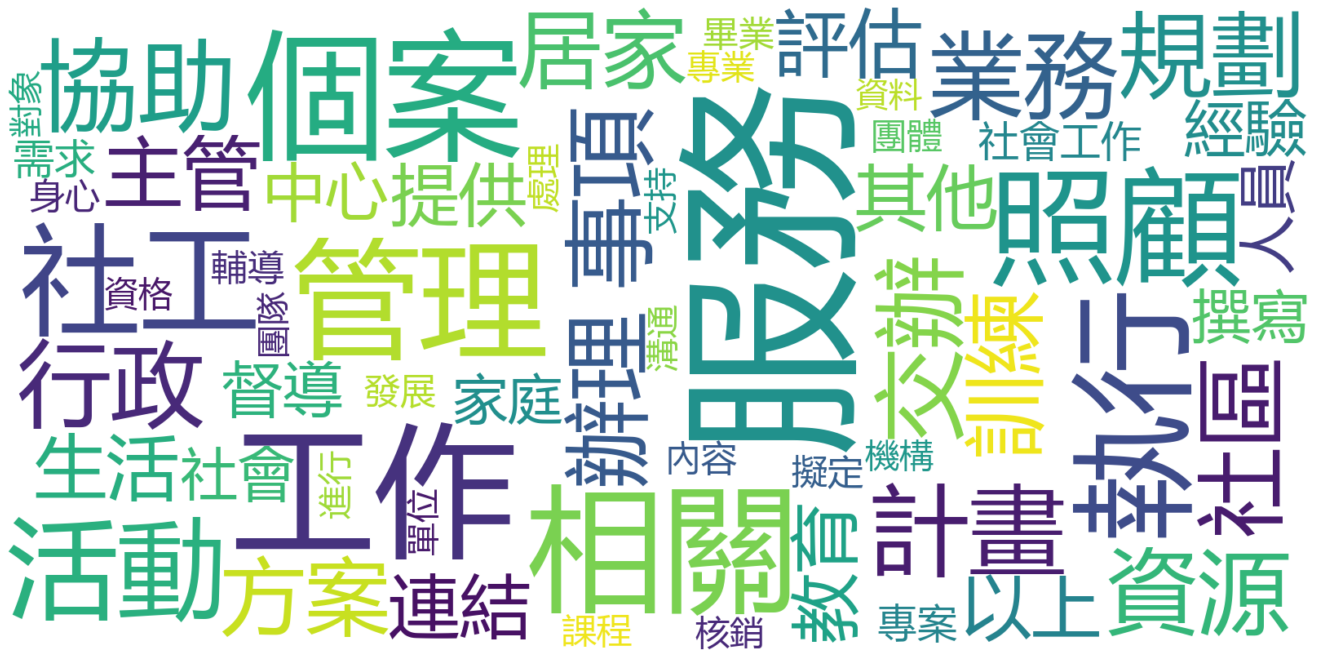

In [22]:
from wordcloud import WordCloud
plt.figure(figsize=(24, 12))
d = {}
# for k,v in zip(Fre_word['index'], Fre_word['Freq']):
for k,v in c.most_common(60):
    d[k] = int(v)
wordcloud = WordCloud(font_path='C:/Windows/Fonts/Microsoft YaHei/msyh.ttc',
                      width=1600,
                      height=800,
                      background_color="white").generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# plt.imshow(wordcloud, interpolation="bilinear")

> 分析: 勞動市場上對於社會學的期待目前還是跟社工當成相同的，要想辦法走出自己的路

# 市場上的勞動狀況怎麼樣？
> 用1.5倍 IQR的方式去除離群值
- 離群值的偵測方式
 - 9倍的平均絕對離差
 - 1.5倍IQR
 - 3倍的Z分數
 - 去除頭尾5%
- 或者你可以直接用中位數來看資料，在這裡選擇用中位數，因為我懶惰XD
- 去除後，計算各科系的中位數待遇，然後繪製bar圖

## 只要年薪、月薪、面議性質的工作

In [23]:
# 只要月薪、面議、與年薪的工作
df_exp_by_major = df_exp_by_major.loc[df_exp_by_major['salaryType'].apply(lambda x: x in [10, 50, 60]), :]
df_exp_by_major.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0


## 各科系的職缺數量

In [24]:
jobcnt_by_majors = df_exp_by_major.groupby('major').size().reset_index()
jobcnt_by_majors.columns = ['major', 'count']
jobcnt_by_majors = jobcnt_by_majors.sort_values('count', ascending=False)
jobcnt_by_majors

,major,count
148,電機電子工程相關,15477
127,資訊工程相關,9560
82,機械工程相關,9167
128,資訊管理相關,5691
54,工程學科類,5611
...,...,...
85,氣象學相關,6
36,哲學相關,6
129,軍事相關,4
34,區域研究相關,2


## 只保留前50大科系的職缺
- join的4種方式

In [25]:
df_exp_by_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,NaN,[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0
1,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0
2,印刷見習技師,康揚特殊美術印刷股份有限公司,不拘,高中、專科、大學,NaN,[],[],1.在印刷機上安裝及調整印版。\r\n2.調整壓力。\r\n3.於印刷機著墨，裝上紙張，並根...,"[{'code': '2010001012', 'description': '印前製作／印...","月薪26,000~36,000元",26000,36000,50,台北市南港區,南港路三段50巷9號5樓,印刷業,26000.0
3,證券營業員(南科分公司),國票綜合證券股份有限公司,不拘,專科以上,NaN,[],[],1.對證券現貨、期貨及新金融商品投資具興趣。 \r\n2.自認可吃苦耐勞、勇於負責者。 \r...,"[{'code': '2003002005', 'description': '金融營業員'...","月薪23,800~40,000元",23800,40000,50,台南市新市區,',證券及期貨業,23800.0
4,美編設計(需具經驗),益盛多媒體印刷有限公司,3年以上,不拘,NaN,"[{'code': '12001003001', 'description': 'A+'},...",[],美編設計人員:需熟Adobe InDesign、Illustrator、Photoshop ...,"[{'code': '2013001005', 'description': '平面設計／美...",待遇面議,0,0,10,新北市中和區,立德街98巷123號2樓,印刷業,40000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,學前教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,綜合教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200726,準公幼貝萊登幼兒園-高年級安親班老師,嘉義市私立貝萊登幼兒園,1年以上,大學以上,專業科目教育相關,[],[],1.協助孩童完成當天功課，並注意寫字的工整。\r\n2.指導國小學生課業，如：幫孩童複習國語...,"[{'code': '2016002008', 'description': '安親班老師'}]",待遇面議,0,0,10,嘉義市,東區林森東路539號,學前教育事業,40000.0
200727,Java程式開發工程師,藍科數位科技股份有限公司,1年以上,專科以上,NaN,"[{'code': '12001003025', 'description': 'Java'}]","[{'code': '11009002008', 'description': '軟體工程系...",Java Web應用程式維護、開發\r\n1. 具備 Java 基礎知識即可，我們很願意帶你...,"[{'code': '2007001004', 'description': '軟體設計工程...","月薪35,000~50,000元",35000,50000,50,台北市內湖區,行愛路151號2樓之2,電腦軟體服務業,35000.0


In [26]:
top50_major = pd.merge(left = df_exp_by_major,
                       right = jobcnt_by_majors.head(50),
                       on ='major',
                       how = 'inner')
top50_major

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin,count
0,汐止分院護理人員(內外科病房.加護病房.門診.安寧病房.護理之家),國泰醫療財團法人國泰綜合醫院,不拘,專科、大學,護理助產相關,[],[],"病人護理照護。\r\n1.護理師月薪41,000~43,000元起\r\n2.包夜班費：4,...","[{'code': '2015001004', 'description': '護理師及護士...","月薪41,000~43,000元",41000,43000,50,新北市汐止區,建成路59巷2號,醫院,41000.0,2791
1,汐止分院-專科護理師(內科.外科),國泰醫療財團法人國泰綜合醫院,不拘,大學,護理助產相關,[],[],"協助、參與病人醫療照護(值班另有優渥津貼)。\r\n1.護理師月薪42,000~50,000...","[{'code': '2015001004', 'description': '護理師及護士...","月薪42,000~50,000元",42000,50000,50,新北市汐止區,建成路59巷2號,醫院,42000.0,2791
2,護理之家護理人員,文雄醫院,1年以上,高中、專科、大學,護理助產相關,[],[],一般護理工作,"[{'code': '2015001004', 'description': '護理師及護士'}]","月薪34,000~36,000元",34000,36000,50,高雄市三民區,察哈爾二街132號(807),醫院,34000.0,2791
3,健檢中心護理師/護士,中心診所醫療財團法人中心綜合醫院,不拘,高中、專科、大學、碩士,護理助產相關,[],[],1.負責執行健檢中心健康檢查服務、抽血、心電圖、量血壓、骨質密度檢查等。\r\n2.提供健康...,"[{'code': '2015001004', 'description': '護理師及護士...","月薪32,000~36,000元",32000,36000,50,台北市大安區,忠孝東路四段77號10樓,醫院,32000.0,2791
4,總院 護理部 內科病房護理人員,國泰醫療財團法人國泰綜合醫院,1年以上,專科、大學,護理助產相關,[],[],內科病房臨床護理工作,"[{'code': '2015001004', 'description': '護理師及護士...","月薪39,000~43,000元",39000,43000,50,台北市大安區,仁愛路四段280號,醫院,39000.0,2791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116264,(Senior) Clinical Research Associate (Taipei/H...,IQVIA_艾昆緯股份有限公司,2年以上,大學以上,醫學系相關,"[{'code': '12001001032', 'description': 'Windo...",[],Join us on our exciting journey!\r\n\r\nIQVIA™...,"[{'code': '2008003002', 'description': '醫藥研發人員...",待遇面議,0,0,10,台北市松山區,民生東路三段138號7樓,生化科技研發業,40000.0,1179
116265,驗光/銷售人員,巴黎三城眼鏡股份有限公司,不拘,專科以上,醫學系相關,[],[],驗光師/驗光生\r\n1.執行非醫療、手術、或藥物之視力檢查及眼鏡處方或矯治。\r\n2.配...,"[{'code': '2005002004', 'description': '門市／店員／...","月薪36,000~70,000元",36000,70000,50,台北市士林區,忠誠路2段55號 大葉高島屋百貨4F,百貨相關業,36000.0,1179
116266,急診科主治醫師,天主教仁慈醫療財團法人仁慈醫院,不拘,大學以上,醫學系相關,[],[],1.執行急診醫療業務。\r\n2.上班時數:6-15班/月(可依彈性需求)。\r\n3.平日...,"[{'code': '2015001001', 'description': '醫師'}]",待遇面議,0,0,10,新竹縣湖口鄉,忠孝路29號,醫院,40000.0,1179
116267,急診醫學科主治醫師,天主教靈醫會醫療財團法人羅東聖母醫院,3年以上,大學以上,醫學系相關,[],[],工作內容：1.執行急診醫療臨床業務\r\n 2.科內相關行政業務\r\n備...,"[{'code': '2015001001', 'description': '醫師'}]",待遇面議,0,0,10,宜蘭縣羅東鎮,中正南路160號(265),醫院,40000.0,1179


## boxplot

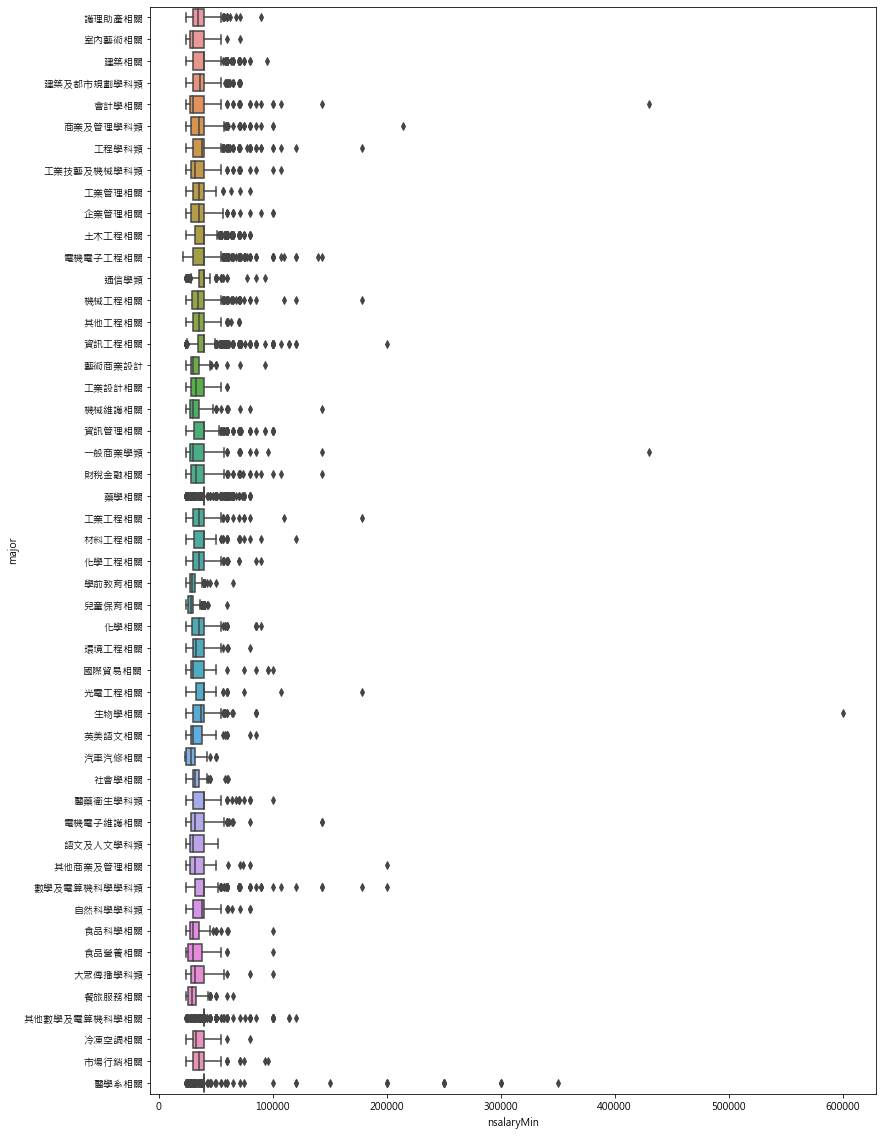

In [27]:
plt.figure(figsize=(13,20))
sns.boxplot(x='nsalaryMin', y='major', data=top50_major, orient='h',)

- 月薪大於10萬的資料不多，把它們丟掉後重新繪圖
- 如果覺得不清楚的還可以再把上限降低~

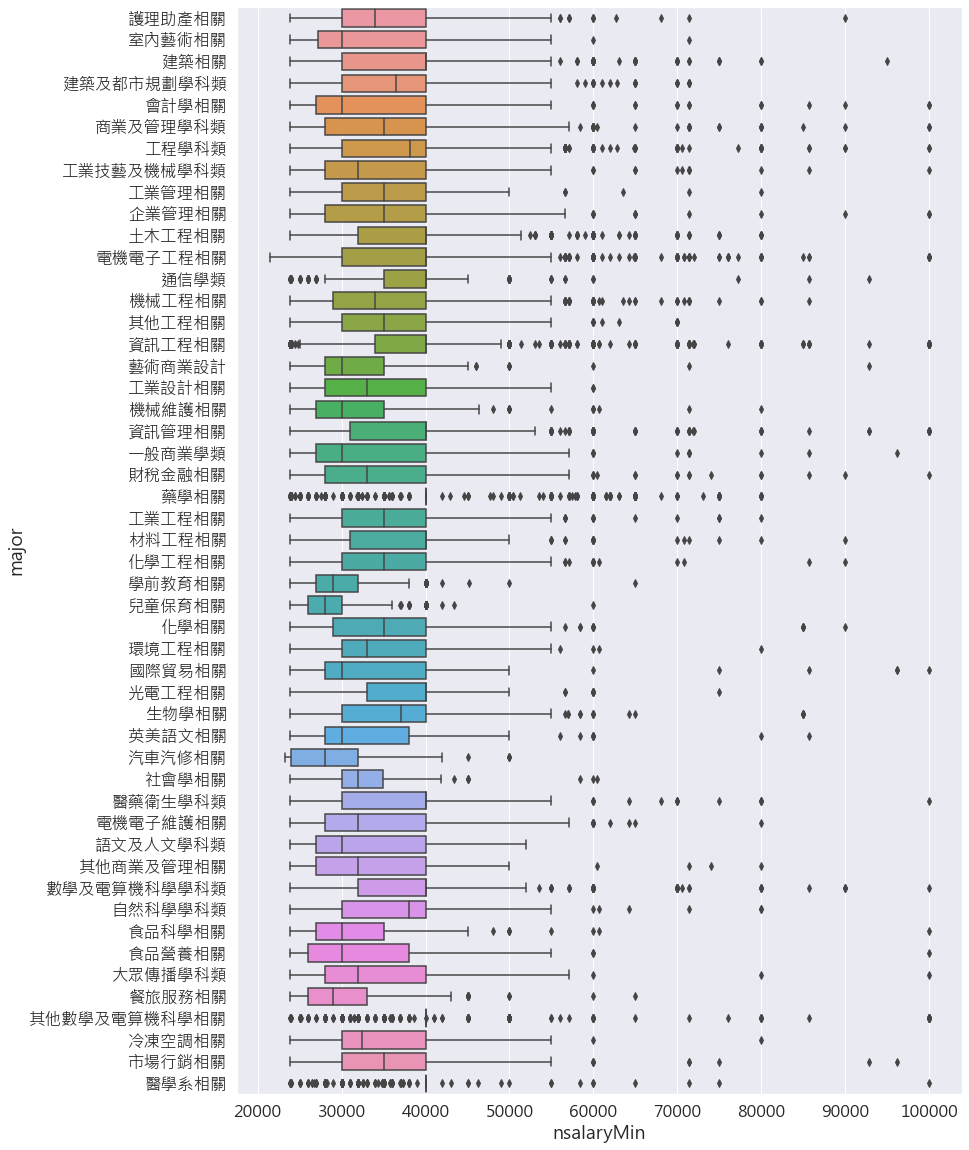

In [28]:
sns.set(font_scale=1.5,font='Microsoft JhengHei')
plt.figure(figsize=(13,20))
sns.boxplot(x='nsalaryMin',
            y='major',
            data=top50_major.loc[top50_major['nsalaryMin']<=100000,:],
            orient='h')
# plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=8) 

# 資料科學的職缺要會哪些技能/工具

In [29]:
df.head(1)

,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
0,作業員,總信食品有限公司,不拘,高中、專科、大學,[],[],[],旺季需配合加班,"[{'code': '2010001002', 'description': '作業員／包裝...","月薪28,000~30,000元",28000,30000,50,台中市南屯區,工業區二十二路17號,食品什貨批發業,28000.0


In [30]:
ds_jobs = df.loc[df['jobName'].apply(lambda x: bool(re.search('數據分析|資料分析|資料科學|大數據|商業分析', x))),:]
print(ds_jobs.shape)
ds_jobs.head(5)

(364, 17)


,jobName,custName,workExp,edu,major,specialty,skill,jobDetail,jobCategory,salary,salaryMin,salaryMax,salaryType,addressRegion,addressDetail,industry,nsalaryMin
5724,集團總部供應鏈大數據管理專員(全球第二大IT通路集團),聯強國際股份有限公司,2年以上,大學以上,[],[],[],"科技產業的供應鏈大數據分析管理, 包含從產品銷售後之預測, 到庫存配置方案, 及透過數據模擬...","[{'code': '2004003002', 'description': '營運管理師／...",待遇面議,0,0,10,台北市中山區,台北總部(台北市中山區民生東路三段75號),電子通訊/電腦週邊批發業,40000.0
9841,大數據平台工程師(亞太地區領導專業配銷商)-T7,群環科技股份有限公司,1年以上,專科、大學、碩士,[],[],[],1. Linux及Windows作業系統日常維運與障礙排除\r\n2. 大數據平台安裝建置(...,"[{'code': '2007002002', 'description': '資料庫管理人...","月薪32,000~70,000元",32000,70000,50,台北市大同區,重慶北路2段243號8樓,電腦系統整合服務業,32000.0
16698,資深資料分析師.,永慶房產集團_永慶房屋仲介股份有限公司,3年以上,大學、碩士,[數理統計相關],[],[],永慶房產集團垂直整合三大事業群，歡迎具備邏輯思考、分析判斷及溝通能力優秀人才的加入，我們提供...,"[{'code': '2004001010', 'description': '市場調查／市...",待遇面議,0,0,10,台北市大安區,敦化南路二段77號12樓,不動產經營業,40000.0
16881,資料分析師.,永慶房產集團_永慶房屋仲介股份有限公司,不拘,大學以上,[],"[{'code': '12001008003', 'description': 'Excel...",[],永慶房產集團垂直整合三大事業群，10年成長25倍，歡迎具備邏輯思考、分析判斷及溝通能力的優秀...,"[{'code': '2004001010', 'description': '市場調查／市...","月薪35,000~40,000元",35000,40000,50,台北市大安區,敦化南路二段77號,不動產經營業,35000.0
17409,C.顧問類-顧問/資深顧問/經理(電腦審計/數據分析/風險管理),資誠聯合會計師事務所,不拘,大學、碩士,"[會計學相關, 資訊管理相關, 商業及管理學科類]",[],[],1. 資訊系統及流程之稽核或診斷諮詢\n2. 內部控制制度之審查或設計諮詢\n3. 資訊系統...,"[{'code': '2018002001', 'description': '顧問人員'}...",待遇面議,0,0,10,台北市信義區,基隆路一段333號,會計服務業,40000.0


In [31]:
df_spec = ds_jobs.loc[:,['specialty']].explode('specialty')
df_spec = df_spec.loc[df_spec['specialty'].notnull(),:]
df_spec['specialty2'] = df_spec['specialty'].apply(lambda x: x['description'])
df_spec

,specialty,specialty2
16881,"{'code': '12001008003', 'description': 'Excel'}",Excel
16881,"{'code': '12001008011', 'description': 'Outlook'}",Outlook
16881,"{'code': '12001008012', 'description': 'PowerP...",PowerPoint
16881,"{'code': '12001008016', 'description': 'Word'}",Word
16881,"{'code': '12003005011', 'description': 'SPSS'}",SPSS
...,...,...
195024,"{'code': '12001003045', 'description': 'Python'}",Python
195024,"{'code': '12001003078', 'description': 'R'}",R
197338,"{'code': '12001003008', 'description': 'C'}",C
197338,"{'code': '12001003010', 'description': 'C++'}",C++


In [32]:
df_spec = df_spec['specialty2'].value_counts().reset_index()
df_spec.head(20)

,index,specialty2
0,Python,98
1,Excel,69
2,MS SQL,47
3,PowerPoint,45
4,R,44
5,Word,42
6,Java,31
7,Tableau,28
8,SAS,24
9,MySQL,21


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8203 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8203 missing from current font.
  font.set_text(s, 0, flags=flags)


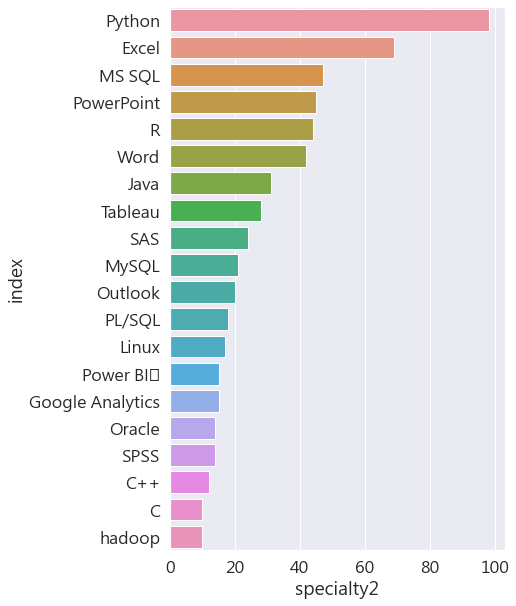

In [33]:
sns.set(font_scale=1.5,font='Microsoft JhengHei')
plt.figure(figsize=(6,10))
sns.barplot(x='specialty2',y='index', data=df_spec.head(20), orient='h')

In [37]:
ds_jobs['major'].value_counts()

[]                                  161
[數學及電算機科學學科類]                         6
[資訊工程相關, 資訊管理相關]                      6
[資訊管理相關, 資訊工程相關]                      5
[電機電子工程相關, 資訊工程相關, 其他數學及電算機科學相關]      4
                                   ... 
[電機電子工程相關, 電機電子維護相關, 資訊工程相關]          1
[材料工程相關, 化學工程相關, 機械工程相關]              1
[企業管理相關, 社會學相關, 數理統計相關]               1
[數理統計相關, 資訊工程相關, 電機電子工程相關]            1
[一般數學相關, 應用數學相關]                      1
Name: major, Length: 142, dtype: int64

In [38]:
161/364

0.4423076923076923

# 提交報告
- 根據前面的發現我們就可以跟傑華老師分享我們的分析結果囉~~
- 第1點的分析可以幫我們了解勞動市場上是怎麼看社會學的學生
> 市場上對於社會學系畢業的學生的期待還是社工，如果要扭轉這種形象建議多舉辦結合社會學與大數據分析的講座並宣傳，例如找學長(誤)
- 第2點的分析我們可以看學跟用之間有沒有落差，反省課綱
> 
- 第3點的分析...
> 

# 總結
- 能完成一件事從來不是單純看能力有多強，而是你有多在乎(Tony, 2020)
- 要有獨立完成分析專案的能力，但你不能只會分析
- - 小提醒：可以多從udemy, udacity取得證書